In [1]:
import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
import pandas as pd
import numpy as np

In [513]:
data = pd.read_csv('data/cpj_dates_codes_alpha.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Type,Date,Name,Sex,Country_killed,Organization,Nationality,...,Local_Foreign,Source_fire,Type_death,Impunity_for_murder,Taken_captive,Threatened,Tortured,clean_dates,Country_code,Alpha_3_codes
0,0,0,0,Motive Confirmed,"October 22, 2016",Ali Risan,Male,Iraq,Al-Sumaria TV,Iraqi,...,Local,Political Group,Crossfire/Combat-Related,NaN,NaN,NaN,\r\r\r\n,2016-10-22,368.0,IRQ
1,1,1,1,Motive Confirmed,"October 21, 2016",Ahmet Haceroğlu,Male,Iraq,Türkmeneli TV,Iraqi,...,Local,Political Group,Crossfire/Combat-Related,NaN,NaN,NaN,\r\r\r\n,2016-10-21,368.0,IRQ
2,2,2,2,Motive Confirmed,"October 2, 2016",Jeroen Oerlemans,Male,Libya,Freelance,Netherlands,...,Foreign,Political Group,Crossfire/Combat-Related,NaN,NaN,NaN,\r\r\r\n,2016-10-02,434.0,LBY
3,3,3,3,Motive Confirmed,"August 14, 2016",Mustafa Said,Male,Iraq,Kurdistan TV,Iraqi,...,Local,Unknown Fire,Crossfire/Combat-Related,NaN,No,No,No\r\r\r\n,2016-08-14,368.0,IRQ
4,4,4,4,Motive Confirmed,"August 8, 2016",Shehzad Ahmed,NaN,Pakistan,Aaj News,Pakistani,...,Local,Political Group,Dangerous Assignment,NaN,No,No,No\r\r\r\n,2016-08-08,586.0,PAK


In [514]:
data.clean_dates = pd.to_datetime(data.clean_dates)
data['year'] = data.clean_dates.dt.to_period("Y")

In [436]:
from bs4 import BeautifulSoup
import requests

In [437]:
import requests
res = requests.get("https://en.wikipedia.org/wiki/ISO_3166-1_numeric#Officially_assigned_code_elements")
soup = BeautifulSoup(res.content,'xml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

df = df.drop(0)

df.iloc[0][0] = "004"
df.columns = ["Country_code", "Country_killed"]
df['Country_code'] = df['Country_code'].astype(float)

In [438]:
counts = data.groupby([data.year, data.Country_killed, data.Country_code, data.Alpha_3_codes]).size().reset_index(name='counts')
#counts = data.groupby([data.Country_killed, data.Country_code]).size().reset_index(name='counts')

In [439]:
counts.head()

,year,Country_killed,Country_code,Alpha_3_codes,counts
0,1992,Algeria,12.0,DZA,1
1,1992,Angola,24.0,AGO,1
2,1992,Azerbaijan,31.0,AZE,1
3,1992,Bosnia,70.0,BIH,8
4,1992,Chad,148.0,TCD,3


In [441]:
counts['year'] = counts['year'].astype(str)

In [442]:
counts['year'] = pd.to_numeric(counts['year'])

In [443]:
counts_all = pd.merge(df, counts, on = 'Country_code', how='left')

In [444]:
counts_all.head()

,Country_code,Country_killed_x,year,Country_killed_y,Alpha_3_codes,counts
0,4.0,Afghanistan,1994.0,Afghanistan,AFG,1.0
1,4.0,Afghanistan,1998.0,Afghanistan,AFG,1.0
2,4.0,Afghanistan,2001.0,Afghanistan,AFG,9.0
3,4.0,Afghanistan,2006.0,Afghanistan,AFG,3.0
4,4.0,Afghanistan,2007.0,Afghanistan,AFG,3.0


In [445]:
counts_all.drop('Country_killed_y',inplace=True, axis=1)

In [446]:
counts_all = counts_all.fillna(0)

In [449]:
counts_all.head()

,Country_code,Country_killed_x,year,Alpha_3_codes,counts
0,4.0,Afghanistan,1994.0,AFG,1.0
1,4.0,Afghanistan,1998.0,AFG,1.0
2,4.0,Afghanistan,2001.0,AFG,9.0
3,4.0,Afghanistan,2006.0,AFG,3.0
4,4.0,Afghanistan,2007.0,AFG,3.0


In [451]:
counts_all['Country_code'] = pd.to_numeric(counts_all['Country_code'])
#counts_all['Country_code'] = counts_all['Country_code'].astype(int)

In [452]:
counts_all.columns = ['Country_code', 'Country', 'year', 'Alpha_3_codes', 'NumberDeaths']

In [453]:
from vega_datasets import data as data_vega
countries = alt.topo_feature(data_vega.world_110m.url, 'countries')

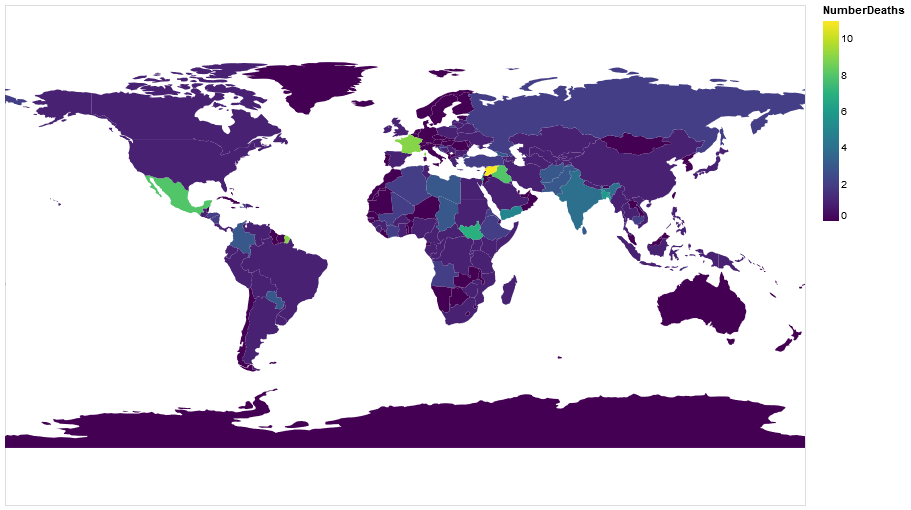

In [454]:
alt.Chart(countries).mark_geoshape().project(
    type='equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(counts_all, 'Country_code', ['Country_code','year','Country','NumberDeaths'])
).encode(
    color='NumberDeaths:Q',
    tooltip=['Country:N','NumberDeaths:Q', 'year:Q'],
).properties(
    width=800,
    height=500,
)

In [455]:
years = np.arange(1992,2017,1)

In [456]:
#years = pd.unique(counts_all.year)
years = pd.DataFrame(years)
years.columns = ['year']

In [457]:
from itertools import product
combo_df = pd.DataFrame(data=list(product(df.Country_code.unique(),years.year.unique())), columns=['Country_code','year']) 
combo_df.head()

,Country_code,year
0,4.0,1992
1,4.0,1993
2,4.0,1994
3,4.0,1995
4,4.0,1996


In [458]:
years.year.unique().shape, counts_all.Country_code.unique().shape

((25,), (249,))

In [459]:
249*25

6225

In [460]:
combo_df[combo_df.Country_code == 4].head()

,Country_code,year
0,4.0,1992
1,4.0,1993
2,4.0,1994
3,4.0,1995
4,4.0,1996


In [461]:
combo_df.dropna(inplace=True)
combo_df.shape

(6225, 2)

In [462]:
counts_all2 = pd.merge(combo_df, counts_all, on = ['Country_code','year'], how='left')

In [463]:
print(counts_all2.shape)
counts_all2.head()

(6225, 5)


,Country_code,year,Country,Alpha_3_codes,NumberDeaths
0,4.0,1992,NaN,NaN,NaN
1,4.0,1993,NaN,NaN,NaN
2,4.0,1994,Afghanistan,AFG,1.0
3,4.0,1995,NaN,NaN,NaN
4,4.0,1996,NaN,NaN,NaN


In [464]:
print(df.shape)
df.head()

(249, 2)


,Country_code,Country_killed
1,4.0,Afghanistan
2,8.0,Albania
3,10.0,Antarctica
4,12.0,Algeria
5,16.0,American Samoa


In [465]:
counts_all2[counts_all2.Country_code.isna()]

,Country_code,year,Country,Alpha_3_codes,NumberDeaths


In [466]:
corrected_countries = []
for i in range(counts_all2.shape[0]):
    cc = counts_all2.iloc[i].Country_code
    name = df[df.Country_code == cc].Country_killed
    #print(type(name.values), name.values.shape, str(name.values[0]))
    #break
    #print(name, cc)
    #counts_all2.iloc[i].Country = name
    #print(counts_all2.iloc[i])# = name
    corrected_countries.append(name.values[0])

counts_all2['Country'] = pd.Series(corrected_countries)

In [467]:
counts_all2 = counts_all2.fillna(0)

In [468]:
counts_all2.head()

,Country_code,year,Country,Alpha_3_codes,NumberDeaths
0,4.0,1992,Afghanistan,0,0.0
1,4.0,1993,Afghanistan,0,0.0
2,4.0,1994,Afghanistan,AFG,1.0
3,4.0,1995,Afghanistan,0,0.0
4,4.0,1996,Afghanistan,0,0.0


In [470]:
counts_all2[counts_all2['Country']=='Yugoslavia']

,Country_code,year,Country,Alpha_3_codes,NumberDeaths


In [35]:
counts_all2.dtypes

Country_code     float64
year               int64
Country           object
Alpha_3_codes     object
NumberDeaths     float64
dtype: object

In [62]:
counts_all3 = counts_all2[counts_all2['year']==2002]

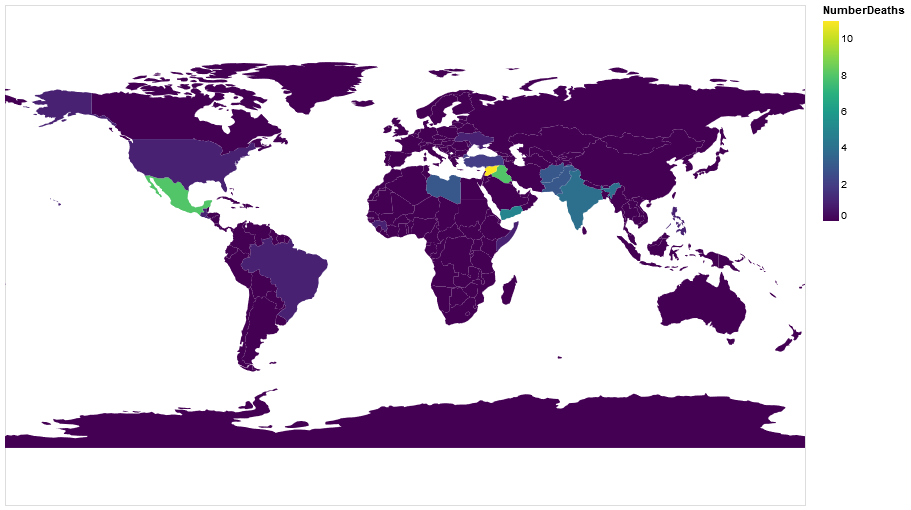

In [120]:
slider = alt.binding_range(min=2000, max=2016, step=1)
year_s = alt.selection_single(name="year", fields=['year'], bind=slider)

alt.Chart(countries).mark_geoshape().project(
    type='equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(counts_all3, 'Country_code', ['year','Country','NumberDeaths'])
).encode(
    color='NumberDeaths:Q',
    tooltip=['Country:N', 'NumberDeaths:Q', 'year:Q'],
).properties(
    width=800,
    height=500,
).add_selection(
    year_s
).transform_filter(
    year_s
)

In [ ]:
from altair import Chart, Color, Scale

In [326]:
counts_all3= counts_all2[counts_all2['year']==2016]

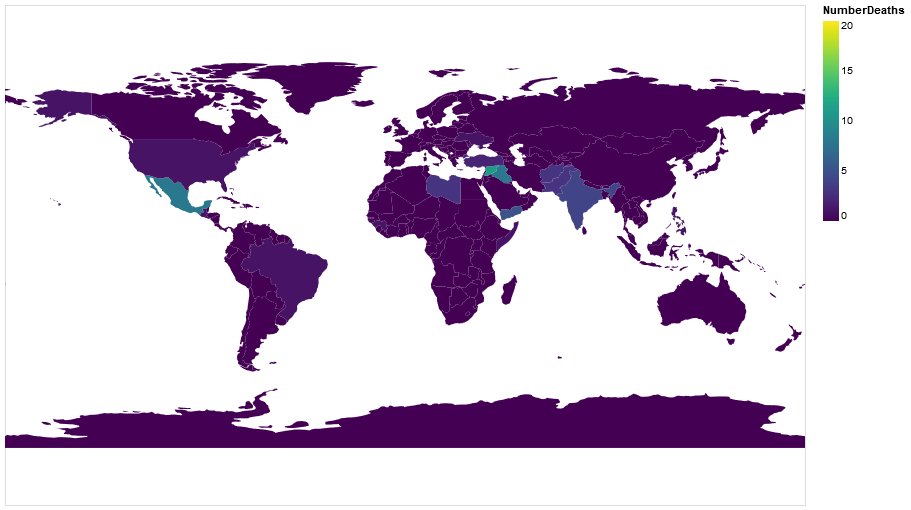

In [327]:
alt.Chart(countries).mark_geoshape().project(
    type='equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(counts_all3, 'Country_code', ['Country_code','year','Country','NumberDeaths'])
).encode(
    Color('NumberDeaths:Q',
          scale=Scale(domain=(0, 20))),
    tooltip=['Country:N','NumberDeaths:Q', 'year:Q'],
).properties(
    width=800,
    height=500,
)

In [248]:
counts_all2[counts_all2.NumberDeaths>20]

,Country_code,year,Country,Alpha_3_codes,NumberDeaths
78,12.0,1995,Algeria,DZA,24.0
2636,368.0,2003,Iraq,IRQ,21.0
2637,368.0,2004,Iraq,IRQ,38.0
2638,368.0,2005,Iraq,IRQ,27.0
2639,368.0,2006,Iraq,IRQ,55.0
2640,368.0,2007,Iraq,IRQ,51.0
4367,608.0,2009,Philippines,PHL,38.0
5445,760.0,2012,Syrian Arab Republic,SYR,37.0
5446,760.0,2013,Syrian Arab Republic,SYR,30.0


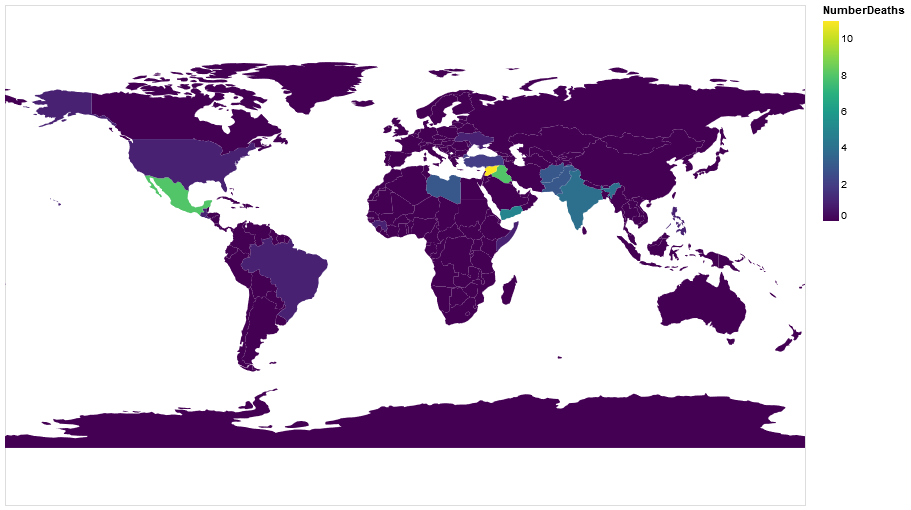

In [174]:
alt.Chart(countries).mark_geoshape().project(
    type='equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(counts_all3, 'Country_code', ['Country_code','year','Country','NumberDeaths'])
).encode(
    color='NumberDeaths:Q',
    tooltip=['Country:N','NumberDeaths:Q', 'year:Q'],
).properties(
    width=800,
    height=500,
)

In [160]:
counts_all4 = counts_all2.groupby(['Country', 'Country_code']).sum().reset_index()
counts_all4.head()

,Country,Country_code,year,NumberDeaths
0,Afghanistan,4.0,50100,36.0
1,Albania,8.0,50100,0.0
2,Algeria,12.0,50100,61.0
3,American Samoa,16.0,50100,0.0
4,Andorra,20.0,50100,0.0


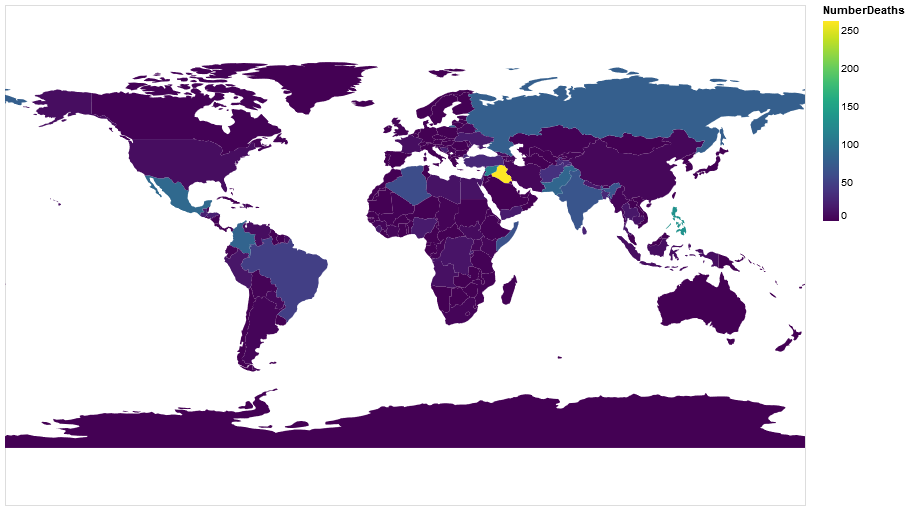

In [161]:
alt.Chart(countries).mark_geoshape().project(
    type='equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(counts_all4, 'Country_code', ['Country_code','Country','NumberDeaths'])
).encode(
    color='NumberDeaths:Q',
    tooltip=['Country:N','NumberDeaths:Q'],
).properties(
    width=800,
    height=500,
)

In [32]:
import plotly.plotly as py
import pandas as pd
import plotly
plotly.tools.set_credentials_file(username='karsanc', api_key='pBTdlMbaH7DZQeBdyOkN')

In [33]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes")
soup = BeautifulSoup(res.content,'xml')
table = soup.find_all('table')[0] 
wiki_df = pd.read_html(str(table))[0]
cols = wiki_df.iloc[0,:]
wiki_df.drop([0,1], inplace = True)
wiki_df.columns = cols
wiki_df.head()
codes = wiki_df[cols[5]]
alpha_3 = wiki_df[cols[4]]

codes_alpha_df = pd.DataFrame()
codes_alpha_df["Country_code"] = codes
codes_alpha_df["Alpha"] = alpha_3

codes_alpha_df["Country_code"] = codes_alpha_df["Country_code"].astype(float)
codes_alpha_df.head()

,Country_code,Alpha
2,4.0,AFG
3,248.0,ALA
4,8.0,ALB
5,12.0,DZA
6,16.0,ASM


In [34]:
counts_all.head()

,Country_code,Country,year,Alpha_3_codes,NumberDeaths
0,4.0,Afghanistan,1994.0,AFG,1.0
1,4.0,Afghanistan,1998.0,AFG,1.0
2,4.0,Afghanistan,2001.0,AFG,9.0
3,4.0,Afghanistan,2006.0,AFG,3.0
4,4.0,Afghanistan,2007.0,AFG,3.0


In [35]:
counts_all2 = pd.merge(codes_alpha_df, counts_all, on = 'Country_code', how='left')

In [36]:
counts_all2.head()

,Country_code,Alpha,Country,year,Alpha_3_codes,NumberDeaths
0,4.0,AFG,Afghanistan,1994.0,AFG,1.0
1,4.0,AFG,Afghanistan,1998.0,AFG,1.0
2,4.0,AFG,Afghanistan,2001.0,AFG,9.0
3,4.0,AFG,Afghanistan,2006.0,AFG,3.0
4,4.0,AFG,Afghanistan,2007.0,AFG,3.0


In [163]:
df = counts_all2

data2 = [ dict(
        type = 'choropleth',
        locations = df['Alpha'],
        z = df['NumberDeaths'],
        text = df['Country'],
        #colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        #    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        #autocolorscale = True,
        #reversescale = True,
        #marker = dict(
        #    line = dict (
        #        color = 'rgb(180,180,180)',
        #        width = 0.5
        #    ) ),
        #colorbar = dict(
        #    autotick = False,
        #    tickprefix = '$',
        #    title = 'GDP<br>Billions US$'),
      ) ]

layout = dict(
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data2, layout=layout )
py.iplot( fig, validate=False )

KeyError: 'Alpha'

In [364]:
import seaborn as sns

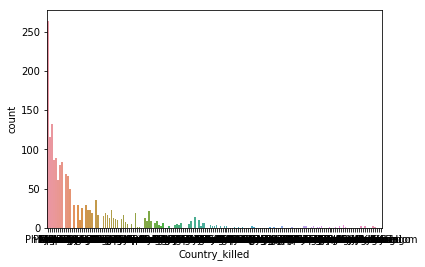

In [365]:
sns.countplot(data = data, x = 'Country_killed', order = data.Nationality.value_counts().index)

In [378]:
period = data.clean_dates.dt.to_period("M")
timeSeries = data.groupby(period).size().reset_index(name='counts')
timeSeries.clean_dates = timeSeries.clean_dates.astype(str)
timeSeries.head()

,clean_dates,counts
0,1992-01,4
1,1992-02,3
2,1992-03,2
3,1992-04,3
4,1992-05,6


In [379]:
import plotly.plotly as py
import plotly.graph_objs as go

pltTS = [go.Scatter(x=timeSeries.clean_dates, y=timeSeries.counts)]

py.iplot(pltTS)

In [380]:
trace = go.Scatter(x=list(timeSeries.clean_dates),
                   y=list(timeSeries.counts))

dataT = [trace]
layout = dict(
    title='Journalists Killed',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),        
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=dataT, layout=layout)
py.iplot(fig, filename='TimeSeries')

In [333]:
counts_all4.sort_values(by='NumberDeaths', inplace=True, ascending=False)
counts_all4.head()

,Country,Country_code,year,NumberDeaths
105,Iraq,368.0,50100,263.0
174,Philippines,608.0,50100,133.0
215,Syrian Arab Republic,760.0,50100,114.0
143,Mexico,484.0,50100,89.0
167,Pakistan,586.0,50100,86.0


In [406]:
counts_all4.iloc[0:7,:]

,Country,Country_code,year,NumberDeaths
105,Iraq,368.0,50100,263.0
174,Philippines,608.0,50100,133.0
215,Syrian Arab Republic,760.0,50100,114.0
143,Mexico,484.0,50100,89.0
167,Pakistan,586.0,50100,86.0
47,Colombia,170.0,50100,84.0
181,Russian Federation,643.0,50100,79.0


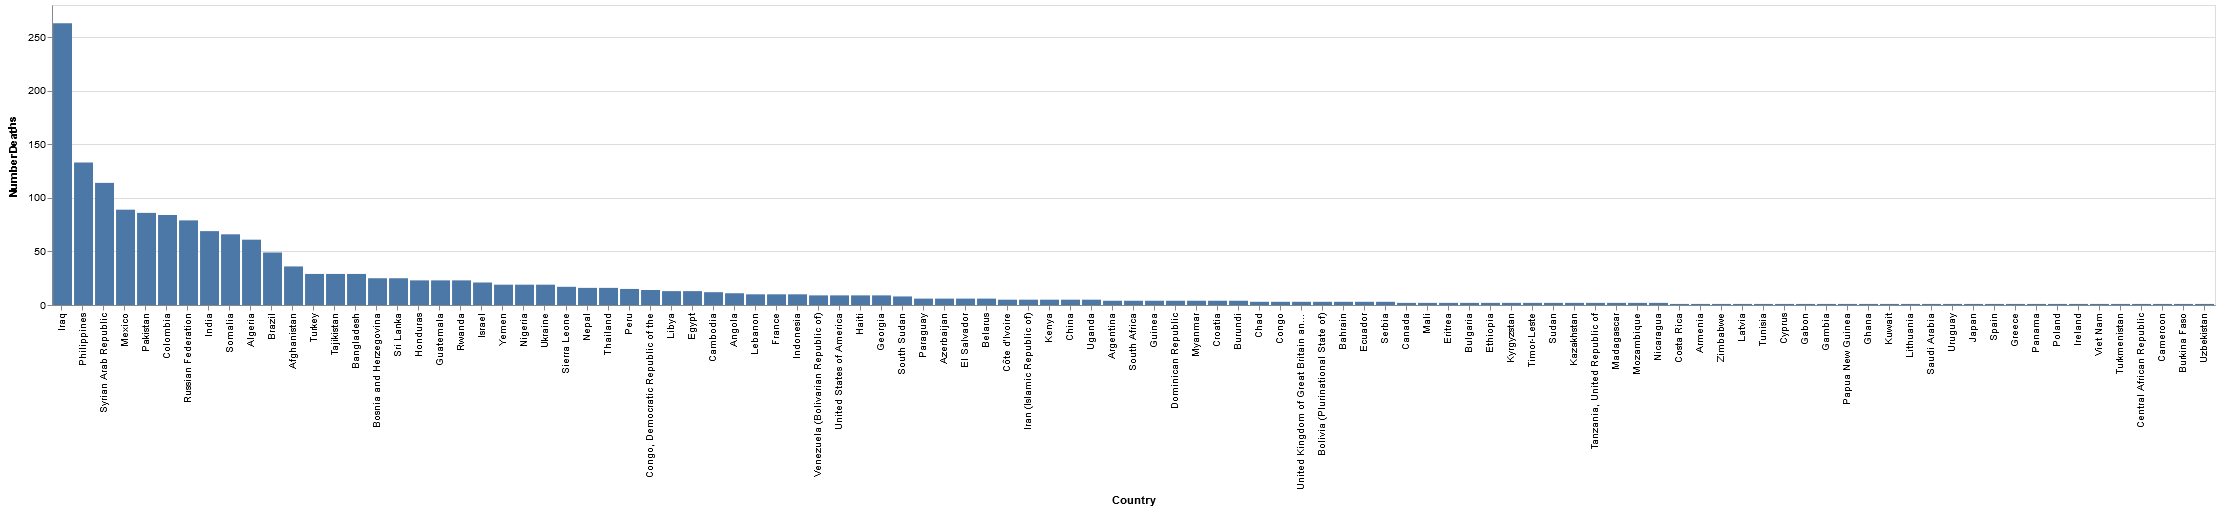

In [347]:
alt.Chart(counts_all4[counts_all4['NumberDeaths']>0]).mark_bar().encode(
    x=alt.X('Country',
            sort=alt.EncodingSortField(field='NumberDeaths', op='sum', order='descending')),
    y='NumberDeaths',
    
    tooltip=['NumberDeaths:Q'],
)

In [475]:
counts_all2.head()

,Country_code,year,Country,Alpha_3_codes,NumberDeaths
0,4.0,1992,Afghanistan,0,0.0
1,4.0,1993,Afghanistan,0,0.0
2,4.0,1994,Afghanistan,AFG,1.0
3,4.0,1995,Afghanistan,0,0.0
4,4.0,1996,Afghanistan,0,0.0


In [481]:
top_countries = counts_all4.iloc[0:5]
top_countries_li = list(top_countries.Country)

timeSeries2 = counts_all2[counts_all2.Country.isin(top_countries_li)]
set(timeSeries2.Country), set(top_countries_li)

({'Iraq', 'Mexico', 'Pakistan', 'Philippines', 'Syrian Arab Republic'},
 {'Iraq', 'Mexico', 'Pakistan', 'Philippines', 'Syrian Arab Republic'})

In [482]:
timeSeries2.head()

,Country_code,year,Country,Alpha_3_codes,NumberDeaths
2625,368.0,1992,Iraq,0,0.0
2626,368.0,1993,Iraq,0,0.0
2627,368.0,1994,Iraq,IRQ,1.0
2628,368.0,1995,Iraq,0,0.0
2629,368.0,1996,Iraq,0,0.0


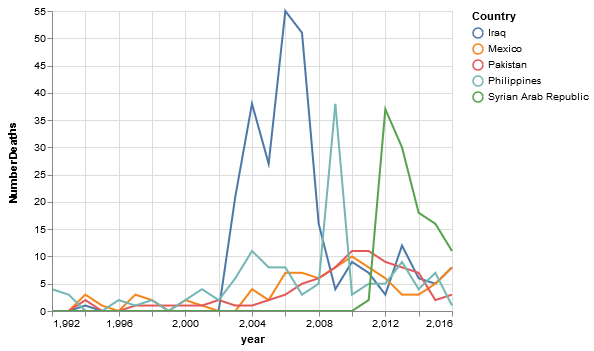

In [498]:
alt.Chart(timeSeries2).mark_line().encode(
    x='year',
    y='NumberDeaths:Q',
    color=alt.Color('Country:N'),
    tooltip=['NumberDeaths:Q'],
)

In [515]:
data = data[data.year.notnull()]
data['year'] = data['year'].astype(str)
sex = data.dropna(subset=['Sex'])#[data['Sex'] == 'null']

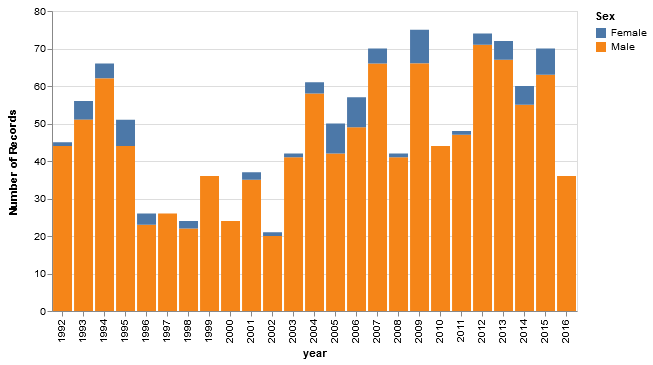

In [516]:
alt.Chart(sex).mark_bar().encode(
    x='year',
    y='count()',
    color='Sex'
)